In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmm_model import *
from numpy import fft
from sklearn import linear_model

In [38]:
def fourier_extrapolation_detrend(x, n_predict):
    #need to recode this, i found it on stackoverflow XD
    n = x.size
    n_harm = 2000                   # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

def fourier_extrapolation(data, n_predict):
    #need to recode this, i found it on stackoverflow XD
    n = data.size
    n_harm = 2000                   # number of harmonics in model
    x_freqdom = fft.fft(data)       # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = range(n)
    indexes.sort(key = lambda i: np.absolute(f[i])) # sort indexes by frequency, lower -> higher

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig



def get_data(symbol, offset, size, column="Open"):
    data_wrapper = DataWrapper("data/{0}.csv".format(symbol), ',')
    end = offset + size
    
    raw_data = data_wrapper.data[column]
    data = np.array(raw_data[offset:end])
    return data


def normalize_data(data):
    n = len(data)
    X = np.ones(shape=(n, 2))
    X[:,0] = np.arange(n)

    Y = data.reshape(n, 1)
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(X, Y)

    coefs = np.array([lin_reg.coef_[0][0], lin_reg.intercept_[0]])
    
    offset_data = np.dot(X, coefs)
    data_normalized = data - offset_data
    return data_normalized, offset_data

def extrapolate_data(data, test_size):
    extrapolation = fourier_extrapolation(data, test_size)
    return extrapolation

    
def split_data(data, test_size):
    data_train = data[:-test_size]
    data_test = data[-test_size:]
    return data_train, data_test


def invert_data_flow(data_flow):
    result = []
    last_value = 0
    for x in data_flow:
        last_value += x
        result.append(last_value)
    return np.array(result)

In [35]:
def get_data_test(symbol, offset, train_size, test_size, draw_plot=True):

    data = get_data(symbol, offset, train_size+test_size)

    if draw_plot:
        plt.plot(data)
        plt.show()

    data_normalized, offset_data = normalize_data(data)
    if draw_plot:
        plt.plot(data_normalized)
        plt.show()

    data_train, data_test = split_data(data_normalized, test_size)

    data_extrapolated = extrapolate_data(data_train, test_size)
    extra_train, extra_test = split_data(data_extrapolated, test_size)

    const_offset = data_test[0] - extra_test[0]

    extra_test_result = extra_test + const_offset
    if draw_plot or True:
        plt.plot(extra_test_result)
        plt.plot(data_test)
        plt.show()

    return sum(np.abs(extra_test_result - data_test))

In [36]:
def get_data_flow_test(symbol, offset, train_size, test_size, draw_plot=True):

    data = get_data(symbol, offset, train_size+test_size)
    data_normalized, offset_data = normalize_data(data)
    data_flow = DataWrapper.get_data_flow(data_normalized)
    if draw_plot:
        plt.plot(data_flow)
        plt.show()

    data_train, data_test = split_data(data_flow, test_size)

    data_extrapolated = extrapolate_data(data_train, test_size)
    extra_train, extra_test = split_data(data_extrapolated, test_size)

    const_offset = data_test[0] - extra_test[0]

    if draw_plot:
        plt.plot(extra_test + const_offset)
        plt.plot(data_test)
        plt.show()

    extra_test_result = extra_test + const_offset

    if draw_plot:
        plt.plot(invert_data_flow(data_test))
        plt.plot(invert_data_flow(extra_test_result))
        plt.show()

    return sum(np.abs(extra_test_result - data_test))


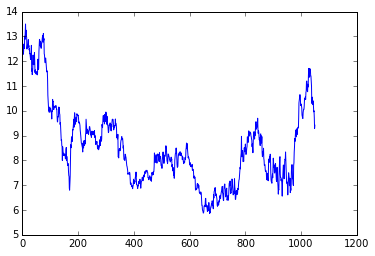

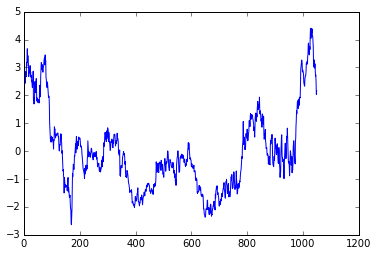

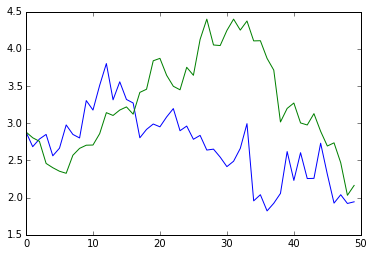

38.68


In [37]:
symbol = "ON"
offset = 150
train_size = 1000
test_size = 50

#for offset in range(50, 1100, 50):
print get_data_test(symbol, offset, train_size, test_size, True)
    #print get_data_flow_test(symbol, offset, train_size, test_size, False)